# Neural Network after Dimensionality Reduction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import load_iris
from keras.utils import to_categorical
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.layers import Dense, Activation, BatchNormalization, InputLayer, Dropout
from keras.models import Sequential
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import pickle
import sys
import sqlite3

sns.set()

2022-11-04 09:31:11.548713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 09:31:11.548728: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
def cluestering(dataset, algorithm: str, n_clusters: int, out_file_name: str=None):
	if type(dataset) == str:
		df = pd.read_csv(dataset, ',', header=None)
	elif type(dataset) == pd.DataFrame:
		df = dataset
	else:
		try:
			df = pd.DataFrame(dataset)
		except ValueError:
			raise TypeError("dataset must be a pandas dataframe or a path to a csv file")
	if algorithm == "kmeans":
		algo = KMeans(
			n_clusters=n_clusters,
			n_init=30
		)
	elif algorithm == "EM":
		algo = GaussianMixture(
			n_components=n_clusters,
			n_init=30,
			init_params='kmeans'  # can also be kmeans or random !
		)
	else:
		raise ValueError("algorithm must be one of 'kmeans' or 'EM'")
	algo.fit(X=df)
	p = algo.predict(X=df)
	dfp = df.assign(label=p)
	if out_file_name is not None:
		dfp.to_csv(out_file_name, sep=',', encoding='utf-8', header=None)
	return dfp, algo

def reduce_dimension(dataset, algorithm: str, nb_of_dimention: int, out_file=None, plot_curve=False, labels=None):
	if type(dataset) == str:
		df = pd.read_csv(dataset, ',', header=None)
	elif type(dataset) == pd.DataFrame:
		df = dataset
	else:
		try:
			df = pd.DataFrame(dataset)
		except ValueError:
			raise TypeError("dataset must be a pandas dataframe or a path to a csv file")
	if algorithm == "PCA":
		algo = PCA(
			n_components=nb_of_dimention,
			svd_solver='full'
		)
	elif algorithm == 'ICA':
		algo = FastICA(
			n_components=nb_of_dimention
		)
	elif algorithm == 'random':
		algo = GaussianRandomProjection(
			n_components=nb_of_dimention
		)
	elif algorithm == 'LDA':
		algo = LinearDiscriminantAnalysis(
			n_components=nb_of_dimention,
			solver='eigen',
			shrinkage='auto'
		)
		if labels is None:
			raise ValueError("Labels must be given when using LDA algorithm (but are use less in other case)")
	else:
		raise ValueError("Unknow algorithm, please use one of: 'PCA', 'ICA', 'LDA' or 'random'")
	algo.fit(
		X=df,
		y=labels
	)
	tdf = algo.transform(X=df)
	tdf = pd.DataFrame(tdf, columns=list(map(str, range(nb_of_dimention))))
	if out_file is not None:
		tdf.to_csv(out_file, sep=',', encoding='utf-8')
	if plot_curve:
		if algorithm == 'PCA':
			eigenvalues = algo.explained_variance_
			score_list = np.zeros((2, len(eigenvalues)), dtype=np.float64)
			old_sum = 0.0
			for i, v in enumerate(eigenvalues):
				old_sum += v
				score_list[0, i] = old_sum
				score_list[1, i] = v
			plt.figure(1)
			plt.plot(range(len(eigenvalues)), score_list[0] / np.max(score_list[0]), label="normalized eigenvalue sum")
			plt.plot(range(len(eigenvalues)), score_list[1] / np.max(score_list[1]), label="normalized eigenvalues")
			plt.legend()
			plt.xlabel("Dimension")
			plt.savefig("../graphics/" + algorithm + "_dimension_importance_" + str(nb_of_dimention) + ".png")
			plt.show()
		elif algorithm == 'LDA':
			# print(algo.covariance_)
			eigenvalues = np.diag(algo.covariance_).copy()
			eigenvalues.sort()
			eigenvalues = np.flip(eigenvalues, 0)
			score_list = np.zeros((2, len(eigenvalues)), dtype=np.float64)
			old_sum = 0.0
			for i, v in enumerate(eigenvalues):
				old_sum += v
				score_list[0, i] = old_sum
				score_list[1, i] = v
			plt.figure(1)
			plt.plot(range(len(eigenvalues)), score_list[0] / np.max(score_list[0]), label="normalized eigenvalue sum")
			plt.plot(range(len(eigenvalues)), score_list[1] / np.max(score_list[1]), label="normalized eigenvalues")
			plt.legend()
			plt.xlabel("Dimension")
			# plt.savefig("../graphics/" + algorithm + "_dimension_importance_" + str(nb_of_dimention) + ".png")
			plt.show()
		else:
			raise ValueError('Curve not yet implemented for other algorithm than PCA')
	return tdf, algo

def load_iris_to_df():
	iris = load_iris()
	df = pd.DataFrame(iris['data'], columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
	df = df.assign(label=iris['target'])
	return df

def load_gender_to_df():
	df = pd.read_csv("../data/gender_x_all.csv", header=0)
	# normalize data set
	min_df, max_df = np.min(df, 0), np.max(df, 0)
	df[:] -= min_df
	df[:] /= max_df - min_df
	# add label
	df_lb = pd.read_csv("../data/gender_y_all.csv", header=0)
	df = df.assign(label=df_lb['label'])
	return df

def plot_2d(df: pd.DataFrame, x_axis: str, y_axis: str, label_axis: str='label', comment=""):
	fig, ax = plt.subplots()
	ax.scatter(df.get(x_axis), df.get(y_axis), c=df.get(label_axis), cmap='gist_ncar', linewidths=1, edgecolors='black')
	ax.set_xlabel(x_axis.replace('_', ' '), fontsize=15)
	ax.set_ylabel(y_axis.replace('_', ' '), fontsize=15)
	if comment != "":
		comment += "_"
	plt.savefig("../graphics/" + comment + x_axis + "_" + y_axis + "_" + label_axis + ".png")
	plt.show()

def plot_3d(df: pd.DataFrame, x_axis: str, y_axis: str, z_axis: str, label_axis: str='label', comment=""):
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')
	ax.scatter(df.get(x_axis), df.get(y_axis), df.get(z_axis), c=df.get(label_axis), s=5, depthshade=False, cmap='gist_ncar')
	ax.set_xlabel(x_axis.replace('_', ' '), fontsize=10)
	ax.set_ylabel(y_axis.replace('_', ' '), fontsize=10)
	ax.set_zlabel(z_axis.replace('_', ' '), fontsize=10)
	if comment != "":
		comment += "_"
	plt.savefig("../graphics/3D_" + comment + x_axis + "_" + y_axis + "_" + z_axis + "_" + label_axis + ".png")
	plt.show()

def get_model(feature_count, class_count, hidden_layer, use_batch_norm=True, optimizer='rmsprop', activation='sigmoid'):
	return_model = Sequential()
	return_model.add(InputLayer(input_shape=(feature_count,)))
	if use_batch_norm:
		return_model.add(BatchNormalization())
	for neurones in hidden_layer:
		return_model.add(Dense(neurones))
		return_model.add(Activation(activation))
		if use_batch_norm:
			return_model.add(BatchNormalization())
	return_model.add(Dense(class_count))
	return_model.add(Activation('softmax'))

	return_model.compile(optimizer=optimizer,
						 loss='categorical_crossentropy',
						 metrics=['categorical_accuracy'])

	return return_model

def get_data(number_of_feature: int, algorithm: str):
	TRAIN_DATASET_LENGHT = 1951
	g = load_gender_to_df()
	label = g.get('label')
	g = g.drop('label', 1)
	data, algo = reduce_dimension(g[:TRAIN_DATASET_LENGHT],
								  algorithm,
								  number_of_feature,
								  labels=label[:TRAIN_DATASET_LENGHT]
								  )
	x_train = data[:TRAIN_DATASET_LENGHT]
	y_train = label[:TRAIN_DATASET_LENGHT]

	x_test = algo.transform(X=g[TRAIN_DATASET_LENGHT:])
	y_test = label[TRAIN_DATASET_LENGHT:]
	return x_train, y_train, x_test, y_test

def perceptron(number_of_features, dim_reduction_algrithm, number_of_epoch, hidden_neurons=((35,),),
			   use_batch_norm_values=(True,), optimizer_values=('rmsprop',),
			   activation_values=('sigmoid',), training_sizes=(-1,), out_file_name=None):

	df = pd.DataFrame()
	for num_feature in number_of_features:
		for algo in dim_reduction_algrithm:
			x_learn, y_learn, x_test, y_test = get_data(num_feature, algo)
			y_learn = to_categorical(y_learn, 200)
			y_test = to_categorical(y_test, 200)
			for opt in optimizer_values:
				for act in activation_values:
					for use_batch_norm in use_batch_norm_values:
						for layers in hidden_neurons:
							for train_limit in training_sizes:
								_, features = x_learn.shape
								_, classes = y_learn.shape
								model = get_model(features, classes, layers, use_batch_norm, opt, act)
								h = model.fit(x=np.array(x_learn[:train_limit]),
											  y=np.array(y_learn[:train_limit]),
											  batch_size=len(x_learn[:train_limit]),
											  epochs=number_of_epoch,
											  validation_data=(np.array(x_test),
															   np.array(y_test)),
											  verbose=0
											  )
								epoch = h.epoch
								h_values = h.history.values()
								values = np.array([epoch, ] + list(h_values))
								tmp = pd.DataFrame(data=values.T, columns=["epoch", ] + list(h.history.keys()))
								tmp = tmp.assign(use_batch_norm=pd.Series([use_batch_norm] * number_of_epoch))
								tmp = tmp.assign(optimizer=pd.Series([opt] * number_of_epoch))
								tmp = tmp.assign(activation=pd.Series([act] * number_of_epoch))
								tmp = tmp.assign(layers=pd.Series([str(layers)] * number_of_epoch))
								tmp = tmp.assign(train_size=pd.Series([str(train_limit)] * number_of_epoch))
								tmp = tmp.assign(reduction_method=pd.Series([algo] * number_of_epoch))
								tmp = tmp.assign(number_of_feature=pd.Series([num_feature] * number_of_epoch))
								if out_file_name is None:
									df = df.append(tmp, ignore_index=True)
								else:
									path = "../stats/" + out_file_name + ".csv"
									if not os.path.exists("../stats"):
										os.makedirs("../stats")
									if os.path.exists(path):
										tmp.to_csv(path_or_buf=path, mode='a', header=False)
									else:
										tmp.to_csv(path_or_buf=path)
	return df

def generate_sql_z_query(z_name: str, filters: dict):
	where_close = ""
	first_key = True
	for k, lf in filters.items():
		if first_key:
			first_key = False
		else:
			where_close += "AND "
		where_close += "("
		first = True
		for v in lf:
			if not first:
				where_close += " OR "
			else:
				first = False
			where_close += str(k)+"='"+str(v)+"'"
		where_close += ") "
	query = "SELECT DISTINCT "+z_name+" FROM per"
	if where_close != "":
		query += " WHERE " + where_close
	return query

def generate_sql_xy_query(x_name: str, y_name: str, z_name: str, z_value, filters: dict, x_limit):
	where_close = z_name+" = '"+str(z_value)+"' "
	for k, lf in filters.items():
		where_close += "AND ("
		first = True
		for v in lf:
			if not first:
				where_close += " OR "
			else:
				first = False
			where_close += str(k)+"='"+str(v)+"'"
		where_close += ") "
	if x_limit > 0:
		where_close += "AND " + x_name + " < " + str(x_limit) + " "
	query = ("SELECT " + x_name + ","
			 "min(" + y_name + ") as min,"
			 "max(" + y_name + ") as max,"
			 "median(" + y_name + ") as median,"
			 "avg(" + y_name + ") as mean "
			 "FROM per ")
	if where_close != "":
		query += "WHERE " + where_close
	query += "GROUP BY " + x_name
	return query

def consolidate_data_from_db(con, x_name: str, y_name: str, z_name: str, filters: dict, x_limit=-1):
	z_value_df = pd.read_sql_query(generate_sql_z_query(z_name, filters), con)
	cd = dict()
	for i in z_value_df.get(z_name):
		query = generate_sql_xy_query(x_name, y_name, z_name, i, filters, x_limit)
		print("Selecting data for", z_name, "=", i)
		cd[i] = pd.read_sql_query(query, con)
	return cd

def generate_plot(con, x_arg_name, y_arg_name, z_arg_name, filters, save_to_file=True, x_limit=-1, x_name=None, y_name=None):
	if x_name is None:
		x_name = x_arg_name
	if y_name is None:
		y_name = y_arg_name
		
	cd = consolidate_data_from_db(con, x_arg_name, y_arg_name, z_arg_name, filters, x_limit)
	
	plt.figure()
	plt.axes()
	for a, d in cd.items():
		plt.plot(d.get(x_arg_name), d.get('median'), 
				 label=z_arg_name.replace('_', ' ') + ' = ' + str(a).replace('_', ' '))
		# plt.fill_between(d.get(x_arg_name), d.get('mean') - d.get('std'), d.get('mean') + d.get('std'), alpha=0.3)
		plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
	if y_arg_name == "val_categorical_accuracy":
		plt.ylabel("Validation accuracy")
	else:
		plt.ylabel(y_name.replace('_',' '))
	plt.xlabel(x_name.replace('_',' '))
	plt.legend()
	# plt.title("Evolution of acuracy acording to the number of training examples")
	if save_to_file:
		algo_name = "all_"
		if "reduction_method" in filters.keys():
			algo_name = '_'.join(map(str, filters["reduction_method"])) + '_'
		layers = ""
		if "layers" in filters.keys():
			layers = '_' + '_'.join(map(lambda x: x.replace('(','').replace(')','').replace(',',''), filters["layers"]))
		plt.savefig("../graphics/"+algo_name+x_name+"_"+y_name+"_"+z_arg_name+layers+".png")
	plt.show()

In [4]:
# result = perceptron(
# 	number_of_features=(1, 2, 3, 4, 5, 6), # (1,)
# 	dim_reduction_algrithm=('PCA', 'ICA', 'random'), # 'LDA'
# 	number_of_epoch=1500,
# 	hidden_neurons=((), (35,), (25,), (15,), (10,), (30, 10), (20, 10)),
# 	use_batch_norm_values=(True,),
# 	optimizer_values=('rmsprop',),
# 	activation_values=('sigmoid', 'relu', 'linear', 'selu'),
# 	training_sizes=(-1,),
# 	out_file_name="perceptron"
# )

con = sqlite3.connect("./data.db")
# con.execute((
# 	'CREATE TABLE IF NOT EXISTS "per" ('
# 		'"ln" INTEGER,'
# 		'"epoch" INTEGER,'
# 		'"val_loss" REAL,'
# 		'"val_categorical_accuracy" REAL,'
# 		'"loss" REAL,'
# 		'"categorical_accuracy" REAL,'
# 		'"use_batch_norm" TEXT,'
# 		'"optimizer" TEXT,'
# 		'"activation" TEXT,'
# 		'"layers" TEXT,'
# 		'"train_size" INTEGER,'
# 		'"reduction_method" TEXT,'
# 		'"number_of_feature" INTEGER'
# 	');'
# ))
# con.execute('CREATE INDEX "RM" on "per" ("reduction_method");')
# con.execute('CREATE INDEX "NF" on "per" ("number_of_feature");')
con.enable_load_extension(True)
con.load_extension("./extension-functions")
# df = pd.read_csv(
# 	"../stats/perceptron.csv",
# 	names=(
# 		"ln", 
# 		"epoch", 
# 		"val_loss",
# 		"val_categorical_accuracy",
# 		"loss",
# 		"categorical_accuracy",
# 		"use_batch_norm",
# 		"optimizer",
# 		"activation",
# 		"layers",
# 		"train_size",
# 		"reduction_method",
# 		"number_of_feature"
# 	)
# )
# df.to_sql("per", con, if_exists='append', index=False)

## General Information

Selecting data for reduction_method = ICA
Selecting data for reduction_method = LDA
Selecting data for reduction_method = PCA
Selecting data for reduction_method = RP


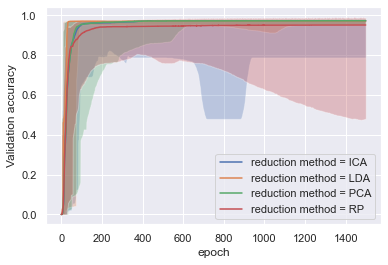

In [5]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='reduction_method',
	filters={},
	x_limit=1500
)

Selecting data for reduction_method = ICA
Selecting data for reduction_method = LDA
Selecting data for reduction_method = PCA
Selecting data for reduction_method = RP


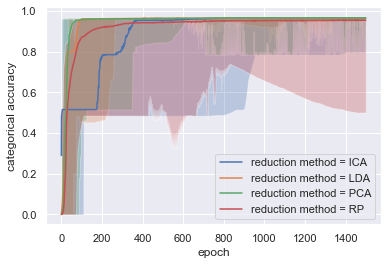

In [6]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='categorical_accuracy',
	z_arg_name='reduction_method',
	filters={},
	x_limit=1500
)

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


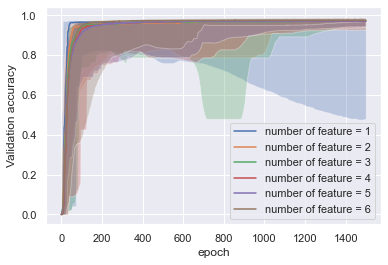

In [7]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={},
	x_limit=1500
)

## PCA

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


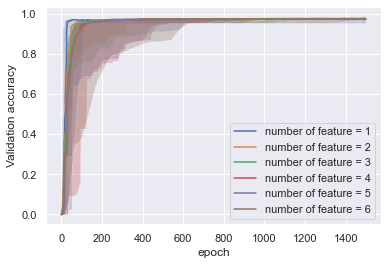

In [44]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['PCA']},
	x_limit=1500
)

Selecting data for layers = ()
Selecting data for layers = (35,)
Selecting data for layers = (25,)
Selecting data for layers = (15,)
Selecting data for layers = (10,)
Selecting data for layers = (30, 10)
Selecting data for layers = (20, 10)


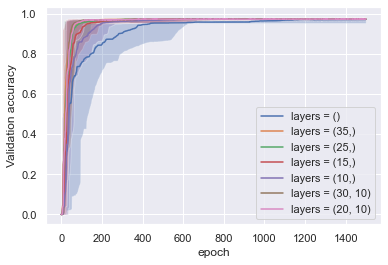

In [45]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='layers',
	filters={'reduction_method': ['PCA']},
	x_limit=1500
)

Selecting data for layers = (30, 10)
Selecting data for layers = (20, 10)


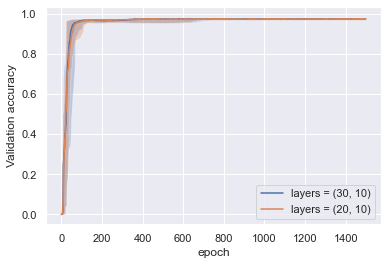

In [47]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='layers',
	filters={'reduction_method': ['PCA'], 'layers': ["(30, 10)", "(20, 10)"]},
	x_limit=1500
)

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


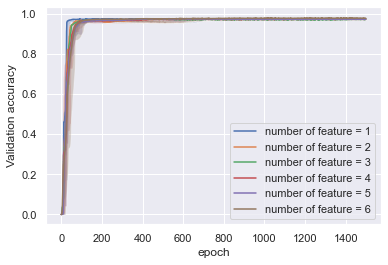

In [48]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['PCA'], 'layers': ["(30, 10)", "(20, 10)"]},
	x_limit=1500
)

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


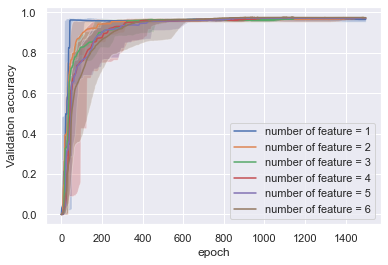

In [49]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['PCA'], 'layers': ["(10,)", "()"]},
	x_limit=1500
)

## ICA

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


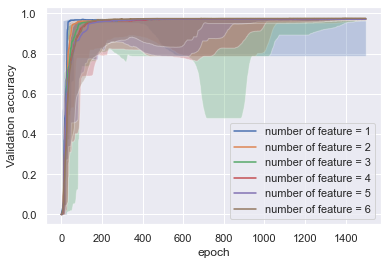

In [13]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['ICA']},
	x_limit=1500
)

Selecting data for layers = ()
Selecting data for layers = (35,)
Selecting data for layers = (25,)
Selecting data for layers = (15,)
Selecting data for layers = (10,)
Selecting data for layers = (30, 10)
Selecting data for layers = (20, 10)


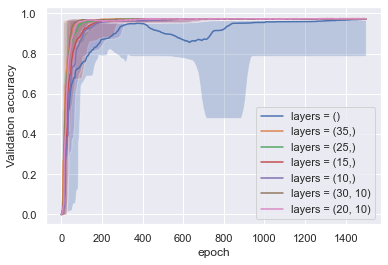

In [14]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='layers',
	filters={'reduction_method': ['ICA']},
	x_limit=1500
)

Selecting data for layers = ()
Selecting data for layers = (10,)


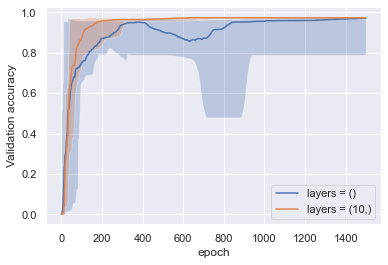

In [50]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='layers',
	filters={'reduction_method': ['ICA'], 'layers': ["(10,)", "()"]},
	x_limit=1500
)

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


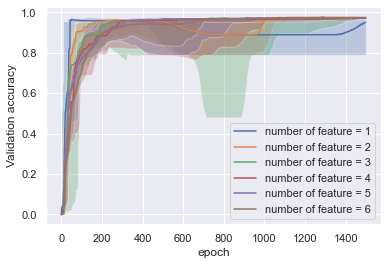

In [51]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['ICA'], 'layers': ["(10,)", "()"]},
	x_limit=1500
)

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


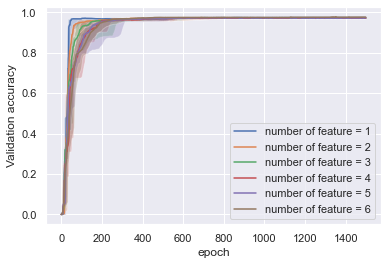

In [17]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['ICA'], 'layers': ["(10,)", "(15,)"]},
	x_limit=1500
)

## RP

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


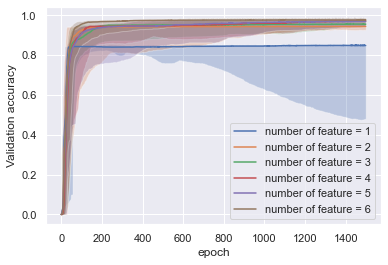

In [28]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['RP']},
	x_limit=1500
)

Selecting data for layers = (35,)
Selecting data for layers = (25,)


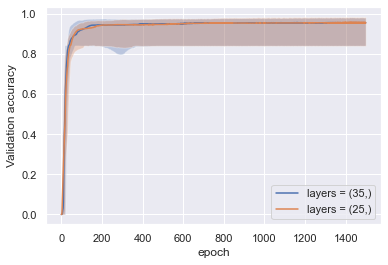

In [29]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='layers',
	filters={'reduction_method': ['RP'], 'layers': ["(35,)", "(25,)"]},
	x_limit=1500
)

Selecting data for layers = ()
Selecting data for layers = (35,)
Selecting data for layers = (25,)
Selecting data for layers = (15,)
Selecting data for layers = (10,)
Selecting data for layers = (30, 10)
Selecting data for layers = (20, 10)


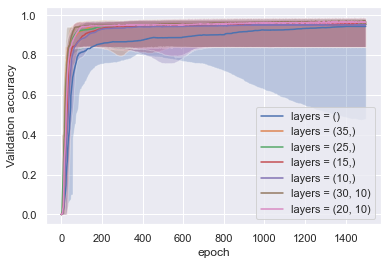

In [52]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='layers',
	filters={'reduction_method': ['RP']},
	x_limit=1500
)

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


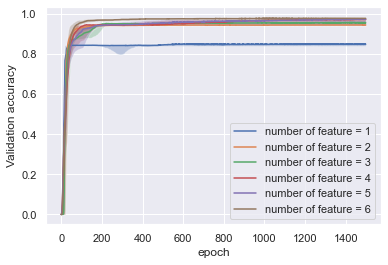

In [31]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['RP'], 'layers': ["(35,)", "(25,)"]},
	x_limit=1500
)

Selecting data for number_of_feature = 1
Selecting data for number_of_feature = 2
Selecting data for number_of_feature = 3
Selecting data for number_of_feature = 4
Selecting data for number_of_feature = 5
Selecting data for number_of_feature = 6


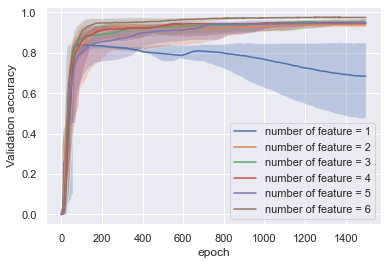

In [53]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['RP'], 'layers': ["(10,)", "()"]},
	x_limit=1500
)

## LDA

Selecting data for number_of_feature = 1


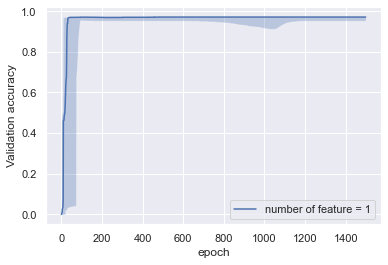

In [5]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['LDA']},
	x_limit=1500
)

Selecting data for number_of_feature = 1


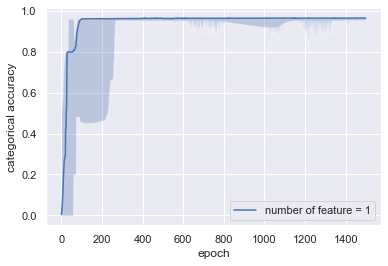

In [6]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['LDA']},
	x_limit=1500
)

Selecting data for layers = ()
Selecting data for layers = (35,)
Selecting data for layers = (25,)
Selecting data for layers = (15,)
Selecting data for layers = (10,)
Selecting data for layers = (30, 10)
Selecting data for layers = (20, 10)


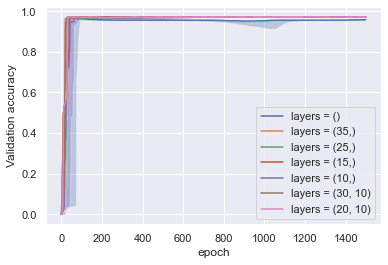

In [7]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='layers',
	filters={'reduction_method': ['LDA']},
	x_limit=1500
)

Selecting data for number_of_feature = 1


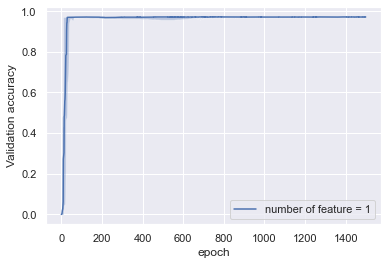

In [9]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['LDA'], 'layers': ["(20, 10)", "(30, 10)"]},
	x_limit=1500
)

Selecting data for number_of_feature = 1


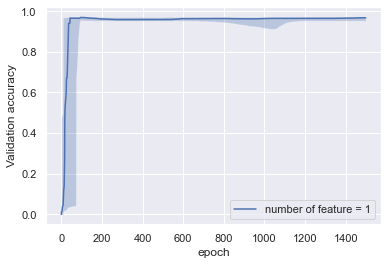

In [8]:
generate_plot(
	con=con,
	x_arg_name='epoch',
	y_arg_name='val_categorical_accuracy',
	z_arg_name='number_of_feature',
	filters={'reduction_method': ['LDA'], 'layers': ["(10,)", "()"]},
	x_limit=1500
)